# Testing a simple workflow

- Import dataset, do some clean up, fix scitypes
- Unpack predictors and response variable
- Load a ridge regressor model
- Create a pipeline with the following steps:
    - Standardize all continuous predictors
    - One hot encode all multiclass predictors
    - Transform target using log
    - Inverse target using exp

In [1]:
using CSV, DataFrames, MLJ, MLJLinearModels, CairoMakie

In [12]:
# Import CSV to dataframe, select some columns
lichen_training = CSV.read("C:/Users/julio/Downloads/lichen_training.csv", DataFrame; missingstring="NA") |>
dropmissing |>
x -> select(x, "Total.lichen", "basal_area", "PL", "mean_Long", "mean_Lat", "SX", "SNR") |>
x -> rename(x, ["biomass", "basalarea", "pl", "lon", "lat", "sx", "snr"]) |>
x -> coerce(x, Count => Continuous, Textual => Multiclass)

lichen_training[!, :log_biomass] = log.(lichen_training[!, :biomass])
select!(lichen_training, Not(:biomass))

schema(lichen_training)

┌─────────────┬───────────────────────────────────┬───────────────┐
│ _.names     │ _.types                           │ _.scitypes    │
├─────────────┼───────────────────────────────────┼───────────────┤
│ basalarea   │ Float64                           │ Continuous    │
│ pl          │ Float64                           │ Continuous    │
│ lon         │ Float64                           │ Continuous    │
│ lat         │ Float64                           │ Continuous    │
│ sx          │ Float64                           │ Continuous    │
│ snr         │ CategoricalValue{String1, UInt32} │ Multiclass{3} │
│ log_biomass │ Float64                           │ Continuous    │
└─────────────┴───────────────────────────────────┴───────────────┘
_.nrows = 77


In [13]:
# Unpack predictors and response variable
y, X = unpack(lichen_training, ==(:log_biomass), _->true);

In [ ]:
# Testing OneHotEncoder
# hot = OneHotEncoder()
# m = fit!(machine(hot, X))
# transform(m, X)

In [14]:
model = @load RidgeRegressor pkg=MLJLinearModels

import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\julio\.julia\packages\MLJModels\GKDnU\src\loading.jl:168


RidgeRegressor

In [15]:
# using MLJBase
pipe = @pipeline Standardizer OneHotEncoder model

Pipeline285(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    one_hot_encoder = OneHotEncoder(
            features = Symbol[],
            drop_last = false,
            ordered_factor = true,
            ignore = false),
    ridge_regressor = RidgeRegressor(
            lambda = 1.0,
            fit_intercept = true,
            penalize_intercept = false,
            solver = nothing))

In [16]:
mach = machine(pipe, X, y)

Machine{Pipeline285,…} trained 0 times; caches data
  args: 
    1:	Source @070 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{3}}}}`
    2:	Source @924 ⏎ `AbstractVector{Continuous}`


In [17]:
fit!(mach)

┌ Info: Training Machine{Pipeline285,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{OneHotEncoder,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Spawning 3 sub-features to one-hot encode feature :snr.
└ @ MLJModels C:\Users\julio\.julia\packages\MLJModels\GKDnU\src\builtins\Transformers.jl:1142
┌ Info: Training Machine{RidgeRegressor,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403


Machine{Pipeline285,…} trained 1 time; caches data
  args: 
    1:	Source @070 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{3}}}}`
    2:	Source @924 ⏎ `AbstractVector{Continuous}`


In [18]:
fp = fitted_params(mach)

(ridge_regressor = (coefs = [:basalarea => -0.718361747351097, :pl => 0.9430804792733228, :lon => -0.896749799411451, :lat => 0.06551504560769857, :sx => 0.1683945791632956, :snr__A => 1.1751653946029175, :snr__B => 1.650542304122004, :snr__C => 0.8487268132723135],
                    intercept = 3.6744345119972235,),
 one_hot_encoder = (fitresult = OneHotEncoderResult,),
 standardizer = Dict(:basalarea => (19.905974025974025, 9.59526339559761), :sx => (9.883116883116884, 23.760301935201667), :lat => (55.97332400649351, 0.5664634649325857), :pl => (57.05194805194805, 43.025052709193105), :lon => (-125.32716337662336, 0.8816506583042382)),
 machines = Machine[Machine{Standardizer,…}, Machine{OneHotEncoder,…}, Machine{RidgeRegressor,…}],
 fitted_params_given_machine = OrderedCollections.LittleDict{Any, Any, Vector{Any}, Vector{Any}}(Machine{Standardizer,…} => Dict(:basalarea => (19.905974025974025, 9.59526339559761), :sx => (9.883116883116884, 23.760301935201667), :lat => (55.9733240064

In [19]:
DataFrame(fp.ridge_regressor.coefs) |> x -> abs.(x)

,basalarea,pl,lon,lat,sx,snr__A,snr__B,snr__C
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.718362,0.94308,0.89675,0.065515,0.168395,1.17517,1.65054,0.848727


In [20]:
yhat = predict(mach);

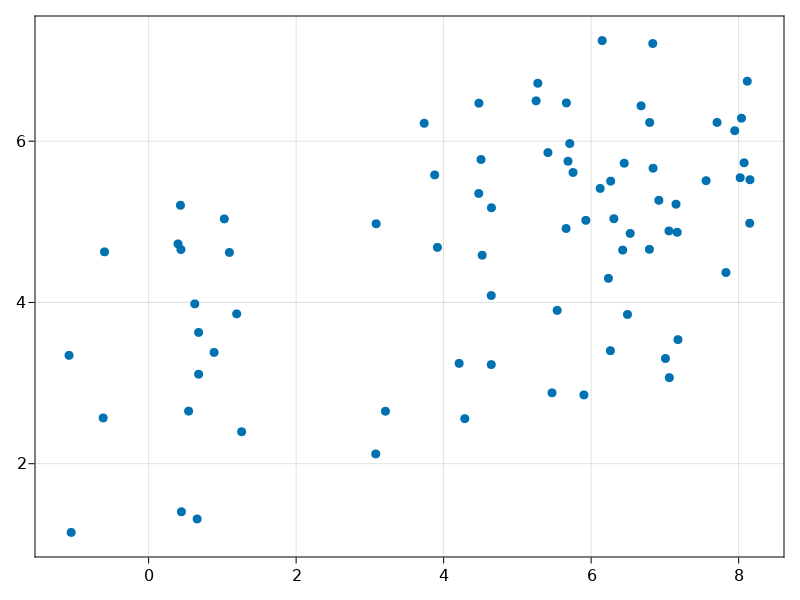

In [22]:
scatter(y, yhat)